<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Extraction" data-toc-modified-id="Feature-Extraction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Extraction</a></span></li><li><span><a href="#Building-our-classifier" data-toc-modified-id="Building-our-classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building our classifier</a></span></li><li><span><a href="#Fine-tuning" data-toc-modified-id="Fine-tuning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fine-tuning</a></span></li></ul></div>

In [1]:
from tensorflow.keras.applications import VGG16,ResNet50
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import pathlib
import os
import numpy as np
%matplotlib inline

In [9]:
conv_base=ResNet50(weights='imagenet',include_top=False,input_shape=(250,250, 3))

In [10]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
!ls "../data/cats_and_dogs"

train
validation
vectorize.py


In [13]:
base_dir="../data/cats_and_dogs"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [15]:
datagen = ImageDataGenerator(rescale=1./255,rotation_range=20)
batch_size = 20

## Feature Extraction

In [16]:
def extract_features(directory, sample_count):
    features=np.zeros(shape=(sample_count,8,8,2048))
    label=np.zeros(shape=(sample_count))
    datagenerator=datagen.flow_from_directory(directory,
                                       batch_size=batch_size,
                                       target_size=(250,250),
                                       class_mode='binary')
    i=0
    for inputs_batch,labels_batch in datagenerator:
        features_batch=conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        label[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size >=sample_count:
            break
        return features,label
    

In [17]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# reshaping the data to shape which will be accepted by the dense layers
train_features=np.reshape(train_features,(2000,8*8*2048))
validation_features=np.reshape(validation_features,(1000,8*8*2048))

## Building our classifier 

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=8 * 8 * 2048))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [11]:
history = model.fit(train_features, train_labels,epochs=6,batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/6
2000/2000 [==============================] - 61s 30ms/sample - loss: 0.7022 - acc: 0.9950 - val_loss: 0.6897 - val_acc: 0.9940
Epoch 2/6
2000/2000 [==============================] - 63s 32ms/sample - loss: 0.6930 - acc: 0.9945 - val_loss: 0.6875 - val_acc: 0.9940
Epoch 3/6
2000/2000 [==============================] - 54s 27ms/sample - loss: 0.6925 - acc: 0.9945 - val_loss: 0.7025 - val_acc: 0.9860
Epoch 4/6
2000/2000 [==============================] - 64s 32ms/sample - loss: 0.6826 - acc: 0.9960 - val_loss: 0.6800 - val_acc: 0.9940
Epoch 5/6
2000/2000 [==============================] - 58s 29ms/sample - loss: 0.6830 - acc: 0.9970 - val_loss: 0.6738 - val_acc: 0.9950
Epoch 6/6
2000/2000 [==============================] - 63s 31ms/sample - loss: 0.6752 - acc: 0.9970 - val_loss: 0.6720 - val_acc: 0.9910


In [12]:
epoch=np.arange(6)+1
epoch

array([1, 2, 3, 4, 5, 6])

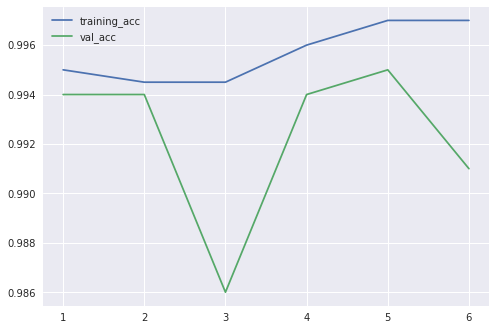

In [13]:
with plt.style.context('seaborn'):
    plt.plot(epoch,history.history['acc'],label='training_acc')
    plt.plot(epoch,history.history['val_acc'],label='val_acc')
    plt.legend()

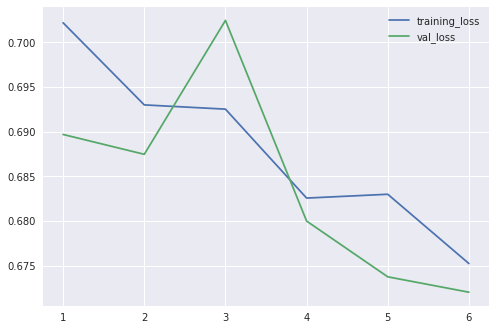

In [14]:
with plt.style.context('seaborn'):
    plt.plot(epoch,history.history['loss'],label='training_loss')
    plt.plot(epoch,history.history['val_loss'],label='val_loss')
    plt.legend()